# Fit BAO peak from input correlation function

In [1]:
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})

from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, project_to_wp, utils, setup_logging
from cosmoprimo import *

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import split_density, compute_densitySplit_CCF
from densitysplit.pk_model import *
from densitysplit.utils import *
from densitysplit.corr_func import *

# To activate logging
setup_logging()

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
#catalog_name = 'AbacusSummit_1Gpc_z1.175'
#bias = 1.8

catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

In [4]:
z = catalog.redshift

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()
f = bg.Omega_m(z)**0.55

## Load correlation function poles

In [5]:
ells = [0, 2]
nells = len(ells)

### Density split

In [6]:
nsplits = 3
nmocks = 1000
abacus_split_results = np.load(output_dir+catalog.name+'_densitySplit_rh_CCFs_cellsize10_randomsize4_RSD.npy', allow_pickle=True)
mocks_split_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_1000_mocks_densitySplit_rh_CCF_cellsize10_randomsize4_RSD_all.npy', allow_pickle=True)

In [7]:
_, split_cov = get_split_poles(mocks_split_results, ells, nsplits)
split_xiell = [abacus_split_results[split].get_corr(ells=ells, return_sep=False) for split in range(nsplits)]
split_cov /= 8

In [8]:
s, _ = abacus_split_results[0].get_corr(ells=ells, return_sep=True)

In [9]:
# Remove small scales (linear model not valid at small scales)
s_lower_limit = 50 # Mpc/h

ns = len(s[s > s_lower_limit])
# Hartlap correction
hartlap = (nmocks-1)/(nmocks-ns*nsplits*nells-2)
split_cov *= hartlap

## Set power spectrum model

In [10]:
pk_model = PkModel(sep=s, ells=ells, xiell=split_xiell, cov=split_cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=True, nsplits=nsplits)
pk_model.set_pk_model()
default_params = {'f': f, 'b1': 2., 'b2': 2., 'b3': 2., 'alpha_par': 1., 'alpha_perp': 1., 'sigma_par': 5., 'sigma_perp': 5., 'sigma_s': 4.}
pk_model.set_default_params(**default_params)
#pk_model.plot_model()

## Fit model to data

In [11]:
# initialize parameters
broadband_coeffs = np.tile([0., 0., 0.], nells)
params_init = {'b1': 2., 'b2': 2., 'b3': 2., 'alpha_par': 1., 'alpha_perp': 1., 'sigma_par': 5., 'sigma_perp': 5., 'broadband_coeffs1': broadband_coeffs, 'broadband_coeffs2': broadband_coeffs, 'broadband_coeffs3': broadband_coeffs}

pk_model.fit_splits(fit_params_init=params_init, s_lower_limit=s_lower_limit)

Optimal parameters:
{'b1': 1.8311963907447024, 'b2': 2.9274339441247057, 'b3': 4.087921834011873, 'alpha_par': 0.9492616198876513, 'alpha_perp': 1.1181267510115696, 'sigma_par': 4.154520081036495, 'sigma_perp': 22.801982302909973, 'broadband_coeffs1': array([-1.24618039e+01,  1.82170754e-01, -7.21945471e-04,  9.20272165e+00,
        4.98178161e-01, -3.26663203e-03]), 'broadband_coeffs2': array([ 2.15363657e+00, -1.11905860e-01,  9.94731605e-04, -4.58881650e+01,
       -7.05448950e-01,  5.36654608e-03]), 'broadband_coeffs3': array([ 4.79935704e+01, -7.05300896e-01,  2.82622328e-03, -1.82096262e+02,
       -1.05468973e+00,  1.00077270e-02])}

Covariance matrix:
[[ 3.96341575e-02  5.15041383e-02  7.81835444e-02  1.43407903e-04
   1.36137960e-03  8.43990619e-02  2.74371944e-01  2.11211192e+00
  -2.93202242e-02  9.10264001e-05  8.75685208e-02 -1.23185988e-02
   5.75923452e-05 -3.99910988e+00  5.50164289e-02 -1.68114284e-04
  -6.96817959e-01  2.26652930e-02 -9.35766484e-05 -8.48877103e+00
  

({'b1': 1.8311963907447024,
  'b2': 2.9274339441247057,
  'b3': 4.087921834011873,
  'alpha_par': 0.9492616198876513,
  'alpha_perp': 1.1181267510115696,
  'sigma_par': 4.154520081036495,
  'sigma_perp': 22.801982302909973,
  'broadband_coeffs1': array([-1.24618039e+01,  1.82170754e-01, -7.21945471e-04,  9.20272165e+00,
          4.98178161e-01, -3.26663203e-03]),
  'broadband_coeffs2': array([ 2.15363657e+00, -1.11905860e-01,  9.94731605e-04, -4.58881650e+01,
         -7.05448950e-01,  5.36654608e-03]),
  'broadband_coeffs3': array([ 4.79935704e+01, -7.05300896e-01,  2.82622328e-03, -1.82096262e+02,
         -1.05468973e+00,  1.00077270e-02])},
 array([[ 3.96341575e-02,  5.15041383e-02,  7.81835444e-02,
          1.43407903e-04,  1.36137960e-03,  8.43990619e-02,
          2.74371944e-01,  2.11211192e+00, -2.93202242e-02,
          9.10264001e-05,  8.75685208e-02, -1.23185988e-02,
          5.75923452e-05, -3.99910988e+00,  5.50164289e-02,
         -1.68114284e-04, -6.96817959e-01,  2.

[000050.80]  05-20 11:35  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000050.80]  05-20 11:35  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000050.81]  05-20 11:35  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000050.81]  05-20 11:35  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000050.96]  05-20 11:35  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000050.96]  05-20 11:35  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000050.97]  05-20 11:35  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000050.97]  05-20 11:35  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral


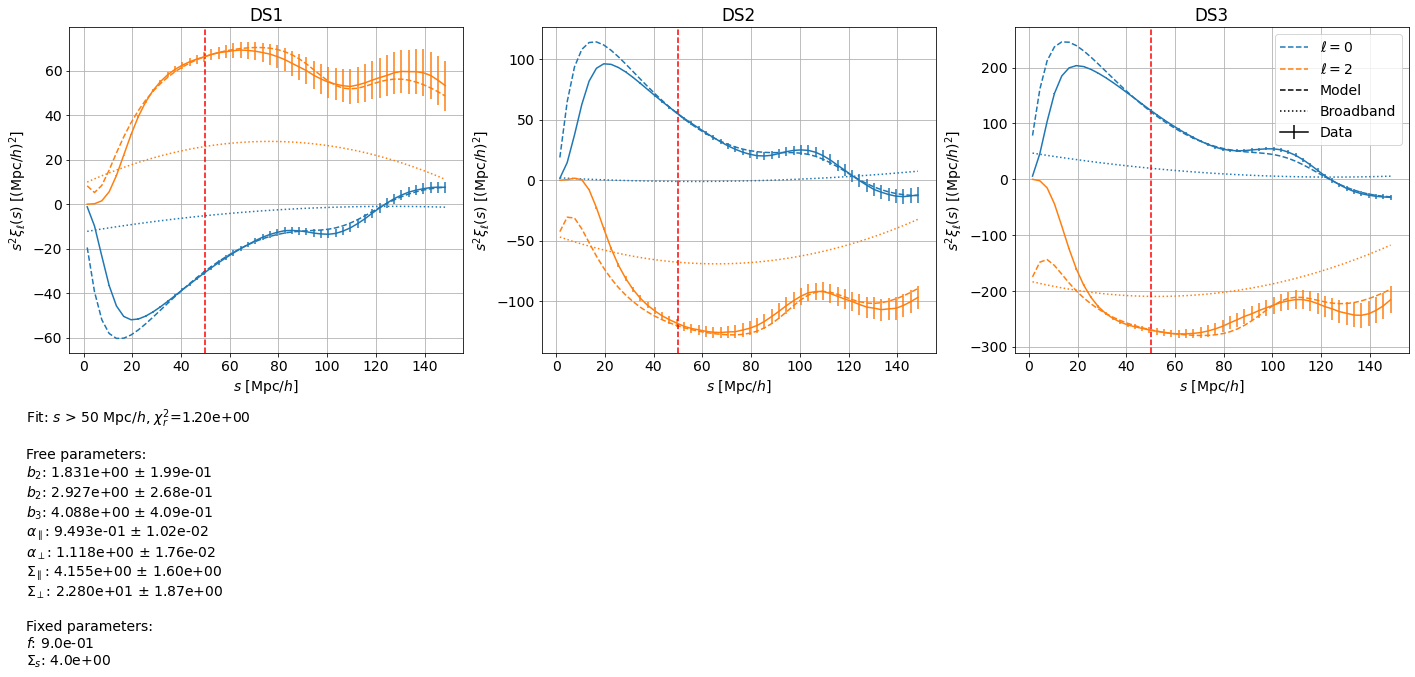

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey = False)

pk_model.plot_model_splits(fig=fig, axes=axes, plot_data=True, show_info=True, show_broadband=True)
#plt.title('DS1 (randoms-halos)')
plt.show()

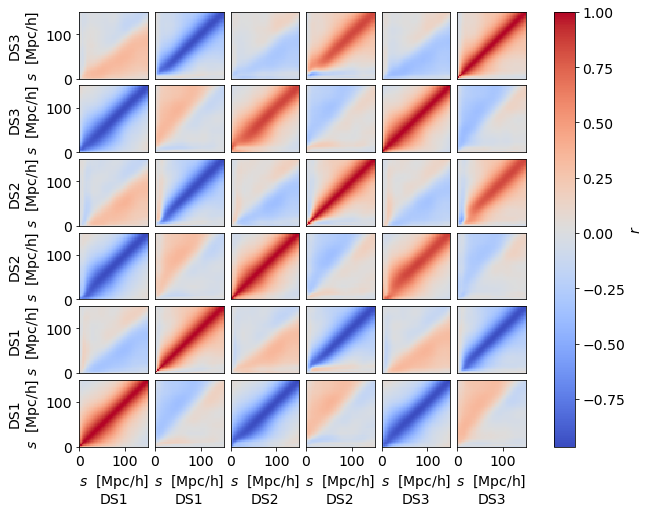

In [13]:
plot_corrcoef(split_cov, ells, s, nsplits)